In [2]:
import pandas as pd
import yfinance as yf
from pandas_datareader import data
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from mytool import *
from kits import *
import pandas_ta as ta
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from torch.functional import F
from torch import nn
import torch
yf.pdr_override()

### RNN

In [29]:
aapl_train = aapl.iloc[:int((len(aapl)-1)*0.8),:]
aapl_test = aapl.iloc[int((len(aapl)-1)*0.8):,:]

In [39]:
exp_seq = aapl_train.shift(-1)
exp_seq.dropna(inplace=True)
exp_seq = torch.from_numpy(exp_seq.values)
train_seq = torch.from_numpy(aapl.drop(aapl_train.index[len(aapl_train)-1]).values)

In [31]:
class myRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(myRNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   

        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):    
        batch_size = x.size(0)
        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)
        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        return out, hidden
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden
    

In [9]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [18]:
model = myRNN(input_size=6, output_size=1, hidden_dim=6, n_layers=1)

model.to(device)

n_epochs = 100
lr=0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    train_seq.to(device)
    output, hidden = model(train_seq)
    loss = criterion(output, exp_seq.view(-1).long())
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

### NN

In [67]:
class myNN(nn.Module):
    def __init__(self):
        super(myNN, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(5, 50),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(50,30),
            nn.ReLU()
        )

        self.linear1 = nn.Sequential(
            nn.Linear(30, 10),
            nn.Dropout(0.2),
            nn.ReLU()
        )

        self.linear2 = nn.Linear(10, 2)

    def forward(self, X):
        X = self.fc1(X)
        X = self.fc2(X)
        X = self.linear1(X)
        #
        X = F.log_softmax(self.linear2(X), dim = 1)
        return X

In [4]:
def get_default_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [79]:
def evaluate(model, val_dl, loss_fn):
    if len(val_dl) == 0:
        return 0, 0
    model.eval()
    correct, total, sum_loss = 0, 0, 0
    for x, y in val_dl:
        x, y = x.to(device), y.to(device)
        y_ = model(x)
        _, pred = torch.max(y_, 1)
        loss = loss_fn(y_, y.long())
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item() * y.shape[0]
    return float(sum_loss) / total, float(correct) / total
def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.

    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate

    Returns:
        The trained model.
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    # Record these values the end of each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    params = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = opt_fn(params, lr=lr)
    for i in range(n_epochs):
        model.train()
        sum_loss, correct, total = 0, 0, 0
        for x, y in train_dl:
            x, y = x.to(device), y.to(device)
            y_ = model(x)
            _, pred = torch.max(y_, 1)
            optimizer.zero_grad()
            loss = loss_fn(y_, y.long())
            loss.backward()
            optimizer.step()
            sum_loss += loss.item() * y.shape[0]
            correct += (pred == y).float().sum()
            total += y.shape[0]
        val_loss, val_acc = evaluate(model, val_dl, loss_fn)
        train_loss = sum_loss / total
        train_acc = float(correct) / total
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [7]:
aapl = read_db("aapl", get_now_date()[0], "test")

In [43]:
aapl = params_preprocesser(aapl, 6).loc[:,["re_close", "re_open", "my_rsi", "Position", "RSI6", "up_or_down"]]
aapl.head()
X = aapl.drop(["up_or_down"], axis = 1)
target = aapl.up_or_down
x_train, x_test, y_train, y_test = train_test_s(X, target, 0.3)

KeyError: 'Open'

In [11]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import dataset

In [74]:
train_ds = []
for i in range(len(x_train)):
    train_ds.append((torch.from_numpy(x_train.iloc[i,:].values).float(), float(y_train.iloc[i])))

test_ds = []
for i in range(len(x_test)):
    test_ds.append((torch.from_numpy(x_test.iloc[i,:].values).float(), float(y_test.iloc[i]*1.0)))

In [75]:
train_dl = DataLoader(train_ds)


# Validation sampler and data loader

test_dl = DataLoader(test_ds)
model = myNN()
device = get_default_device()
print(device)

to_device(model, device)

num_epochs = 30  # Max number of training epochs
loss_fn = F.nll_loss  # Define the loss function
opt_fn = torch.optim.Adam  # Select an optimizer
lr = 1e-4  # Set the learning rate

cuda


In [80]:
history = train_model(num_epochs, model, train_dl, test_dl, loss_fn, opt_fn, lr)

In [81]:
def plot_accuracy(train_accuracies, test_accuracies):
    """Plot accuracies"""
    plt.plot(train_accuracies, "-x")
    plt.plot(test_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")

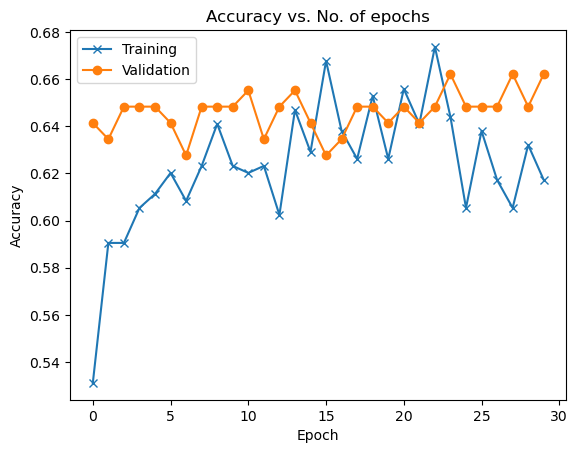

In [82]:
model, train_losses, val_losses, train_accuracies, test_accuracies = history
plot_accuracy(train_accuracies, test_accuracies)